<a href="https://colab.research.google.com/github/ReemAbdelhaleemHassan/Face-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Reading from Google Drive**

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Upload the dataset**

In [ ]:
# upload CSV file from google drive
link = 'https://drive.google.com/file/d/1Mb0WeDv0s1Y3K7f1-3Qp7iFUfFw6K_GF/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('archive.zip')

## **Unzipping**

In [ ]:
! unzip archive.zip -d faces

## **Imports**

In [ ]:
import numpy as np
import cv2 as cv
import os
#from google.colab.patches import cv2_imshow # for image display
#from skimage import io
#from PIL import Image 
import matplotlib.pylab as plt
import matplotlib.pyplot as plt1
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from prettytable import PrettyTable

## **Vectoring the Images**

In [ ]:
def vectorizing(imagename):
  img=cv.imread(imagename)
  result = img[:, :, 0]
  img_np = np.asarray(result)
  img_np= img_np.flatten()
  return img_np

## **Read the dataset**

In [ ]:
directory = os.fsencode("/content/faces/")
dataset = []
for file in sorted(os.listdir(directory)):
      filename = os.fsdecode(file)
      filename= "/content/faces/"+ filename +"/"
      filenameV= os.fsencode(filename)
      for image in os.listdir(filenameV):
        imagename = os.fsdecode(image)
        imagename= filename+imagename
        dataset.append(vectorizing(imagename))


## **Generating the labels vector**

In [ ]:
labels = []
for i in range(1,41):
  for j in range(10):
    labels.append(i)


## **Convert to NumPy**

In [ ]:
dataset = np.array(dataset)
labels = np.array(labels)
print(f"Length of dataset {len(dataset)} and type {type(dataset)}")
print(f"Length of labels {len(labels)} and type {type(labels)}")

Length of dataset 400 and type <class 'numpy.ndarray'>
Length of labels 400 and type <class 'numpy.ndarray'>


## **Dataset Splitting**

In [ ]:
train_features = []
train_labels = []

test_features = []
test_labels = []

# even indices for train and odd for test
for i in range(0,400,2):
  train_features.append(dataset[i])
  train_labels.append(labels[i])
  test_features.append(dataset[i+1])
  test_labels.append(labels[i+1])


## **Convert Train and Test sets to NumPy**

In [ ]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

print(train_features.shape)
print("-------------------------------------------------")
print(test_features.shape)

(200, 10304)
-------------------------------------------------
(200, 10304)


## **PCA**

In [ ]:
def pca(dataset,alpha):
  mean=dataset.mean(axis=0)
  Z=dataset-mean
  cov=np.cov(Z,rowvar=False,bias=False)
  eigen_values,eigen_vectors=np.linalg.eigh(cov)
  r=0
  sum=0.0
  n=len(eigen_values)
  eigen_values=np.abs(eigen_values)
  eigen_values_sum=math.fsum(eigen_values)
  ind=(eigen_values.argsort())
  sorted_eigenvectors=eigen_vectors[:,ind]
  sorted_eigenvalues=eigen_values[ind]
  for i in reversed(range(n)):
    sum=sum+sorted_eigenvalues[i]
    tolerance=float(sum/eigen_values_sum)
    if tolerance>=alpha:
      r=i
      break
  P=sorted_eigenvectors[:,r:n]
  return P

## **Projection**

In [ ]:
def projection(features,P):
  features=features-features.mean(axis=0)
  projected_features=np.dot(features,P)
  return projected_features

## **K-NN Classifier**

In [ ]:
def knn(train_features,train_labels,test_features,test_labels,k):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(train_features,train_labels)
  predicition  = clf.predict(test_features)
  acc = accuracy_score(predicition,test_labels)
  return acc

In [ ]:
def classifierTuningPCA (alpha,projected_train_features,train_labels,projected_test_features,test_labels,accuracyTable):
  accuracies=[]
  for k in range (1,8,2):
    accuracies.append(knn(projected_train_features,train_labels,projected_test_features,test_labels,k))
  accuracyTable.add_row([alpha,accuracies[0],accuracies[1],accuracies[2],accuracies[3]])
  return accuracies

## **Performing PCA on the dataset**

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
accuracies=[]
r=[]
accuracyTable = PrettyTable(["alpha\KNN", "1", "3", "5", "7"])
accuracies_tuning=[]
for i in range(4):
  projection_matrix = pca(train_features,alphas[i])
  projected_train_features = projection(train_features,projection_matrix)
  projected_test_features = projection(test_features,projection_matrix)
  accuracies.append(knn(projected_train_features,train_labels,projected_test_features,test_labels,1))
  accuracies_tuning.append(classifierTuningPCA(alphas[i],projected_train_features,train_labels,projected_test_features,test_labels,accuracyTable))
  r.append(projection_matrix.shape[1])

## **Plotting Relation between Alpha and Accuracy**

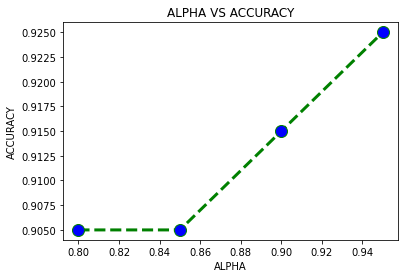

In [ ]:
plt.plot(alphas, accuracies,color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('ALPHA')
plt.ylabel('ACCURACY')
plt.title('ALPHA VS ACCURACY')
plt.show()

## **Plotting relation between number of vectors used and alphas**

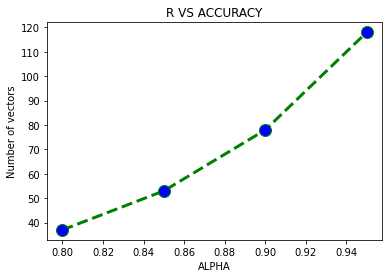

In [ ]:
plt.plot(alphas, r,color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('ALPHA')
plt.ylabel('Number of vectors')
plt.title('R VS ACCURACY')
plt.show()

## **Classifier Tuning with K=1,3,5,7**

In [ ]:
print(accuracyTable)

+-----------+-------+-------+-------+-------+
| alpha\KNN |   1   |   3   |   5   |   7   |
+-----------+-------+-------+-------+-------+
|    0.8    | 0.905 | 0.885 |  0.82 |  0.8  |
|    0.85   | 0.905 |  0.89 | 0.845 | 0.785 |
|    0.9    | 0.915 |  0.89 |  0.83 | 0.785 |
|    0.95   | 0.925 |  0.89 |  0.82 |  0.77 |
+-----------+-------+-------+-------+-------+


## **Plotting relation between K and accuracy at each alpha**

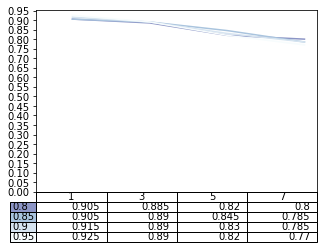

In [ ]:
data = accuracies_tuning
columns = ('1', '3', '5', '7')
rows = ['0.8', '0.85', '0.9', '0.95']
values = np.arange(0, 1, 0.05)
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
colors = colors[::-1]
index = np.arange(len(columns)) + 0.3
bar_width = 0.4
n_rows = len(data)

for row in range(n_rows):
    plt.plot(index, data[row], bar_width, color=colors[row])

plt.table(cellText=data, rowLabels=rows, rowColours=colors, colLabels=columns, loc='bottom')

plt1.subplots_adjust(left=0.25, bottom=0.25)
plt1.ylabel("")
plt1.yticks(values)
plt1.xticks([])
plt1.title('')

plt1.show()

--------------------------------------------------------------------------------


---



## **LDA**

In [ ]:
def lda(train_features,samples):
  Stotal=np.zeros(shape=(train_features.shape[1],train_features.shape[1]))  
  overallmean=train_features.mean(axis=0)
  sum=np.zeros(shape=(train_features.shape[1],train_features.shape[1]))
  for i in range(40):
    c=train_features[samples*i:samples*i+samples]
    mean=c.mean(axis=0)
    c=c-mean
    Stotal+=np.dot(c.transpose(),c)
    meandiff=(mean-overallmean).reshape(train_features.shape[1], 1)
    sum+=samples*np.dot(meandiff,meandiff.T)
  eigen_values, eigen_vectors = np.linalg.eigh(np.dot(np.linalg.inv(Stotal),sum))
  ind=(np.abs(eigen_values).argsort())
  sorted_eigenvectors=eigen_vectors[:,ind]
  sorted_eigenvalues=eigen_values[ind]
  U=sorted_eigenvectors[:,-39:]
  return U

## **Performing LDA on the dataset**

In [ ]:
U=lda(train_features,5)
projected_train_features_lda=projection(train_features,U)
projected_test_features_lda=projection(test_features,U)
accuracy=knn(projected_train_features_lda,train_labels,projected_test_features_lda,test_labels,1)
print(accuracy)
print(U.shape)

0.91
(10304, 39)


## **Classifier tuning for k=1,3,5 and 7**

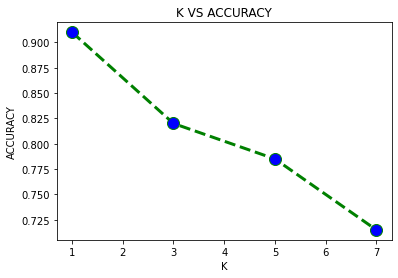

In [ ]:
accuracy=[]
k=[1,3,5,7]
for K in k:
  accuracy.append(knn(projected_train_features_lda,train_labels,projected_test_features_lda,test_labels,K))
plt.plot(k, accuracy,color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('K')
plt.ylabel('ACCURACY')
plt.title('K VS ACCURACY')
plt.show()

## **Built-in Sklearn function for checking**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=39)
X_train = lda.fit_transform(train_features, train_labels)
X_test = lda.transform(test_features)
acc = knn(X_train,train_labels,X_test,test_labels,1)
print(acc)

0.94


## **Changing Splitting Ratio from 50%-50% to 70%-30%**

In [ ]:
train_features2 = []
train_labels2 = []

test_features2 = []
test_labels2 = []


for i in range(0,40):
  for j in range(0,7):
    train_features2.append(dataset[j+10*i])
    train_labels2.append(labels[j+10*i])
  for j in range(7,10):
    test_features2.append(dataset[j+10*i])
    test_labels2.append(labels[j+10*i])

train_features2 = np.array(train_features2)
train_labels2 = np.array(train_labels2)
test_features2 = np.array(test_features2)
test_labels2 = np.array(test_labels2)

print(train_features2.shape)
print("-------------------------------------------------")
print(test_features2.shape)

(280, 10304)
-------------------------------------------------
(120, 10304)


## **Performing PCA on the new data**

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
accuracies=[]
r=[]
accuracyTable = PrettyTable(["alpha\KNN", "1", "3", "5", "7"])
accuracies_tuning=[]
for i in range(4):
  projection_matrix2 = pca(train_features2,alphas[i])
  projected_train_features2 = projection(train_features2,projection_matrix)
  projected_test_features2 = projection(test_features2,projection_matrix)
  accuracies.append(knn(projected_train_features2,train_labels2,projected_test_features2,test_labels2,1))
  accuracies_tuning.append(classifierTuningPCA(alphas[i],projected_train_features2,train_labels2,projected_test_features2,test_labels2,accuracyTable))
  r.append(projection_matrix.shape[1])

## **Plotting Relation between Alpha and Accuracy**

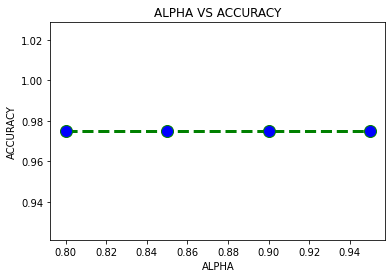

In [ ]:
plt.plot(alphas, accuracies,color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('ALPHA')
plt.ylabel('ACCURACY')
plt.title('ALPHA VS ACCURACY')
plt.show()

In [ ]:
print(r)

[118, 118, 118, 118]


## **Classifier Tuning**

In [ ]:
print(accuracyTable)

+-----------+-------+--------------------+--------------------+--------------------+
| alpha\KNN |   1   |         3          |         5          |         7          |
+-----------+-------+--------------------+--------------------+--------------------+
|    0.8    | 0.975 | 0.9083333333333333 | 0.8583333333333333 | 0.8083333333333333 |
|    0.85   | 0.975 | 0.9083333333333333 | 0.8583333333333333 | 0.8083333333333333 |
|    0.9    | 0.975 | 0.9083333333333333 | 0.8583333333333333 | 0.8083333333333333 |
|    0.95   | 0.975 | 0.9083333333333333 | 0.8583333333333333 | 0.8083333333333333 |
+-----------+-------+--------------------+--------------------+--------------------+


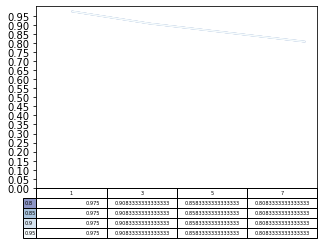

In [ ]:
data = accuracies_tuning
columns = ('1', '3', '5', '7')
rows = ['0.8', '0.85', '0.9', '0.95']
values = np.arange(0, 1, 0.05)
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
colors = colors[::-1]
index = np.arange(len(columns)) + 0.3
bar_width = 0.4
n_rows = len(data)

for row in range(n_rows):
    plt.plot(index, data[row], bar_width, color=colors[row])

plt.table(cellText=data, rowLabels=rows, rowColours=colors, colLabels=columns, loc='bottom')

plt1.subplots_adjust(left=0.25, bottom=0.25)
plt1.ylabel("")
plt1.yticks(values)
plt1.xticks([])
plt1.title('')

plt1.show()

## **Performing LDA on the new data**

In [ ]:
U=lda(train_features2,7)
projected_train_features_lda2=projection(train_features2,U)
projected_test_features_lda2=projection(test_features2,U)
accuracy=knn(projected_train_features_lda2,train_labels2,projected_test_features_lda2,test_labels2,1)
print(accuracy)
print(U.shape)

0.925
(10304, 39)


## **Built-in LDA**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=39)
X_train2 = lda.fit_transform(train_features2, train_labels2)
X_test2 = lda.transform(test_features2)
acc = knn(X_train2,train_labels2,X_test2,test_labels2,1)
print(acc)

0.9666666666666667


## **Classifier Tuning**

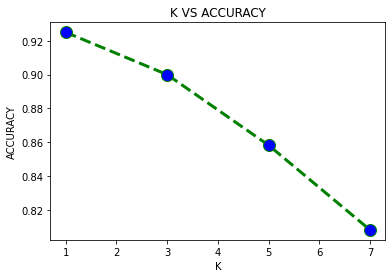

In [ ]:
accuracy=[]
k=[1,3,5,7]
for K in k:
  accuracy.append(knn(projected_train_features_lda2,train_labels2,projected_test_features_lda2,test_labels2,K))
plt.plot(k, accuracy,color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('K')
plt.ylabel('ACCURACY')
plt.title('K VS ACCURACY')
plt.show()